In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

In [8]:
df = pd.read_csv("../find-a-house/clean-funda-2018-02-10.csv", index_col=0)
df.head()

,address,living_area,price,rooms,url
0,Oterleekstraat 15 1023 ED Amsterdam,63.0,319.0,4.0,https://www.funda.nl/en/koop/amsterdam/huis-40...
1,Bastenakenstraat 142 1066 JG Amsterdam,151.0,850.0,4.0,https://www.funda.nl/en/koop/amsterdam/huis-86...
2,Roeselarestraat 11 1066 SW Amsterdam,95.0,350.0,4.0,https://www.funda.nl/en/koop/amsterdam/huis-86...
3,Jan Vrijmanstraat 165 1087 MB Amsterdam,158.0,699.0,5.0,https://www.funda.nl/en/koop/amsterdam/huis-40...
4,Van Boshuizenstraat 547 1082 AV Amsterdam,155.0,700.0,8.0,https://www.funda.nl/en/koop/amsterdam/huis-40...


In [30]:
np.mean(df.price)

680.1537069872277

Let's try to guess a distribution that may match how prices were generated

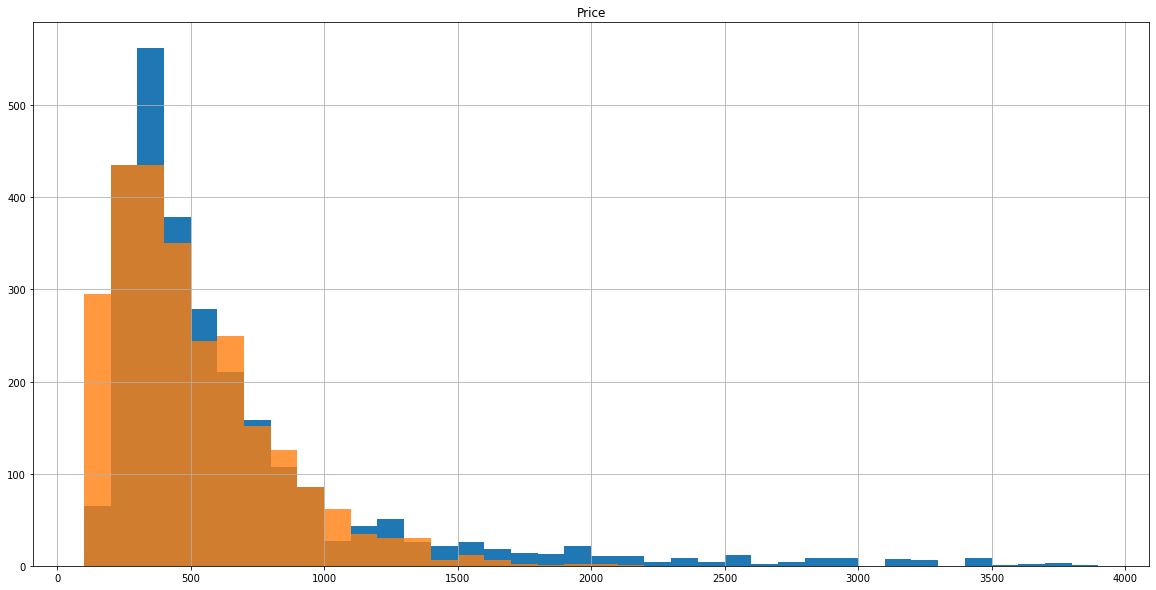

In [369]:
plt.figure(figsize=(20,10))
df.price.hist(bins=range(100, 4000, 100));
plt.hist(np.random.chisquare(5, size=len(df)) * 100, bins=range(100, 4000, 100), alpha=0.8)
plt.title("Price");

In [288]:
def chance_data_is_in_distribution(data, distribution):
    total_chance = 1
    epsilon = 10
    for y in np.random.choice(data, 100):
        chance = len([ 1 for y_ in distribution if abs(y_ - y) <= epsilon ]) / len(distribution)
        chance = max(chance, 0.0000001)
        total_chance *= chance
    return total_chance
        
distribution = np.random.chisquare(2, size=len(df)) * 340
chance_data_is_in_distribution(df.price, distribution)

3.5095178507791257e-202

In [306]:
def test_distribution(alpha, beta):
    distribution = np.random.chisquare(alpha, size=len(df)) * beta
    return chance_data_is_in_distribution(df.price, distribution)

best_result = None
best_combination = ()
for alpha in range(1, 10):
    for beta in range(100, 500, 25):
        result = test_distribution(alpha, beta)
        if best_result is None or (result != 0 and result > best_result):
            best_result = result
            best_combination = (alpha, beta)

print("Best result:", best_combination)

Best result: (2, 275)


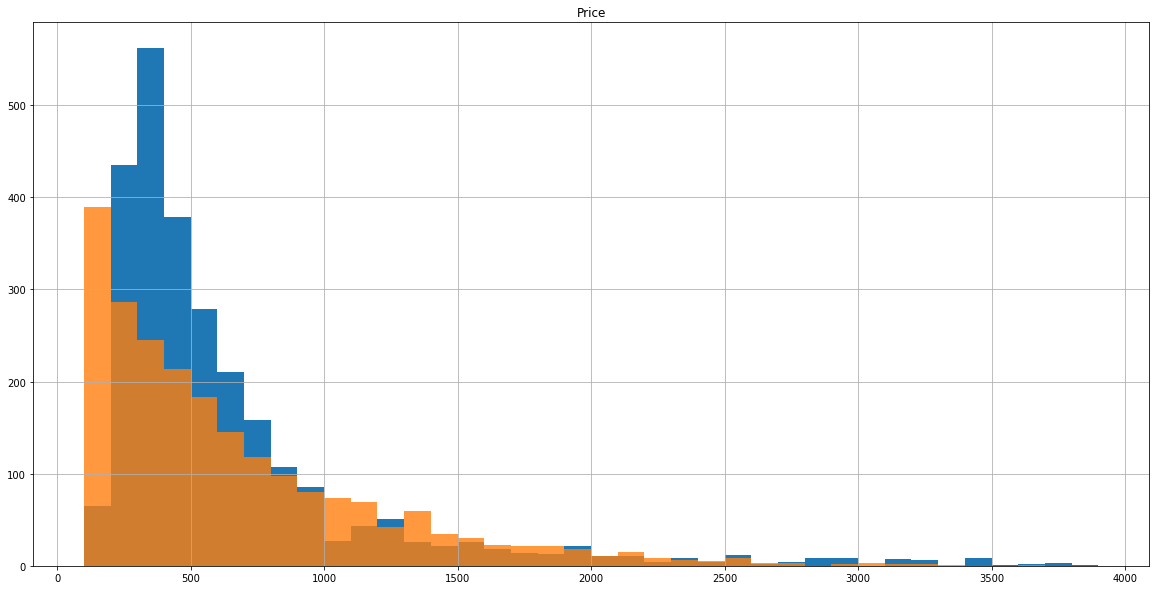

In [368]:
plt.figure(figsize=(20,10))
df.price.hist(bins=range(100, 4000, 100))
plt.hist(np.random.chisquare(2, size=len(df)) * 275, bins=range(100, 4000, 100), alpha=0.8)
plt.title("Price");

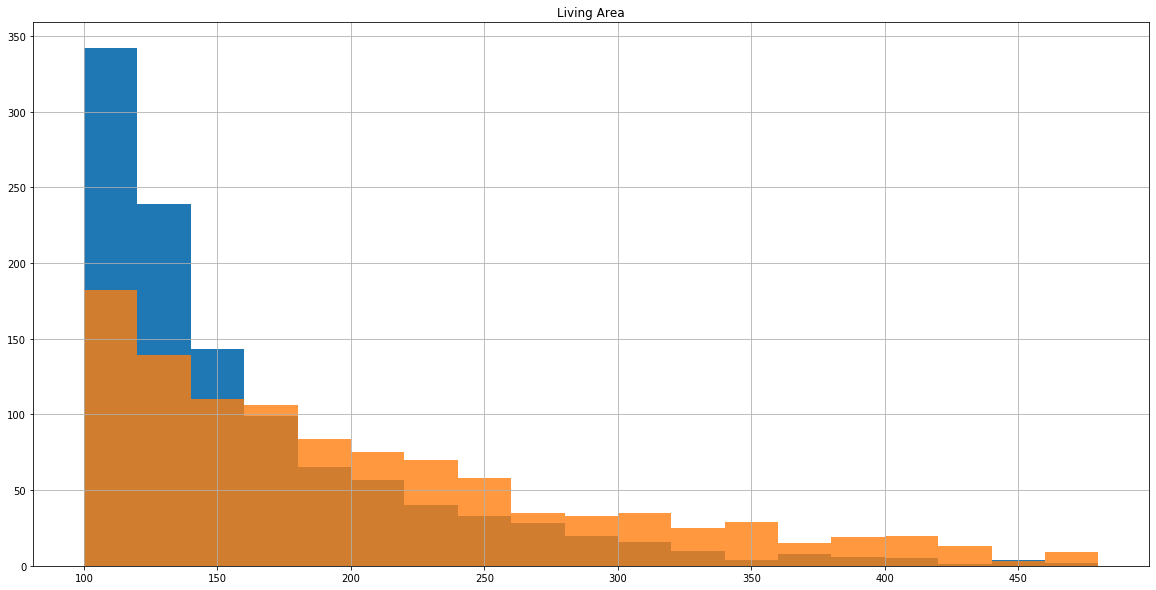

In [371]:
plt.figure(figsize=(20,10))
df.living_area.hist(bins=range(100, 500, 20));
plt.hist(np.random.exponential(df.living_area.mean(), size=len(df)), bins=range(100, 500, 20), alpha=0.8);
plt.title("Living Area");

In [386]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=df.price.mean() * 2)
    lamb = pm.Uniform('lamb', lower=500, upper=5000)
    pior_price = pm.Wald('price', mu, lamb, observed=df.price)
    
    mu_area = pm.Uniform('mu_area', lower=0, upper=df.living_area.mean() * 2)
    lamb_area = pm.Uniform('lamb_area', lower=1, upper=1000)
    living_area = pm.Wald('living_area', mu_area, lamb_area, observed=df.living_area)
    
    trace = pm.sample(1000)
    
print(trace['mu'].mean())
print(trace['lamb'].mean())
print(trace['mu_area'].mean())
print(trace['lamb_area'].mean())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lamb_area, mu_area, lamb, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 701.42draws/s]


680.3119530380355
1254.1711588460776
110.67019229443326
341.4637168680854


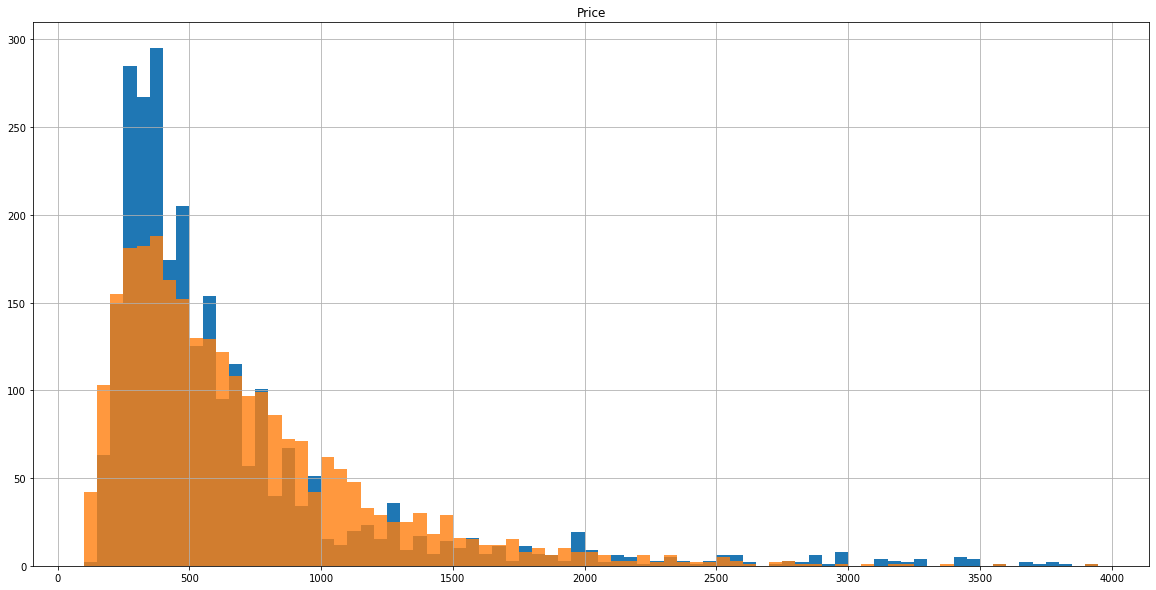

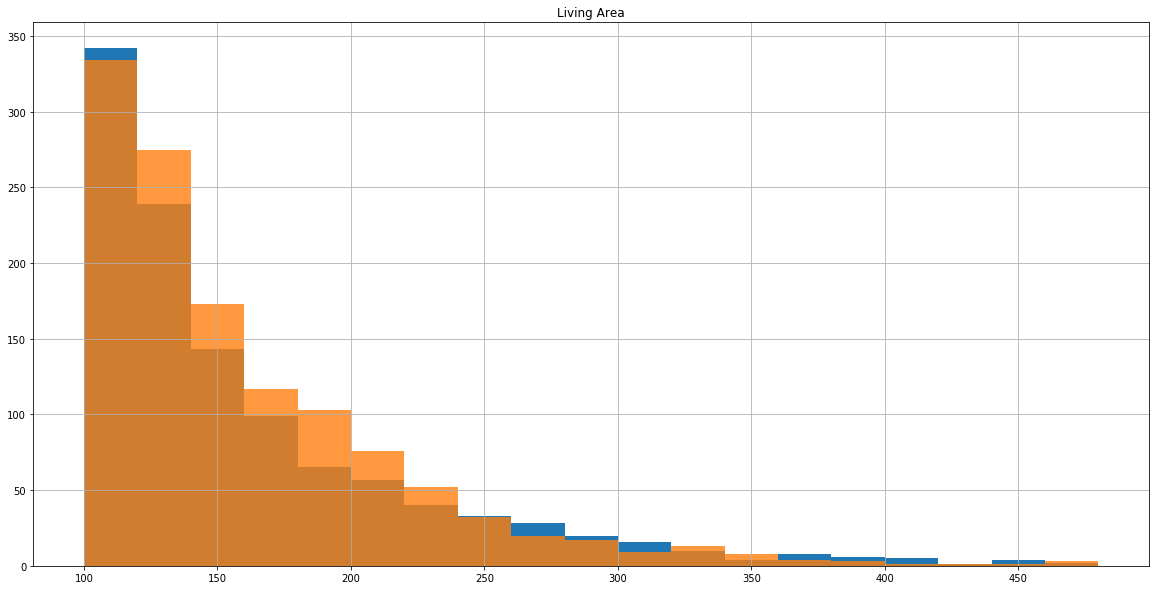

In [375]:
plt.figure(figsize=(20,10))
df.price.hist(bins=range(100, 4000, 50))
plt.hist(np.random.wald(680, 1253, size=len(df)), bins=range(100, 4000, 50), alpha=0.8)
plt.title("Price")
plt.show()

plt.figure(figsize=(20,10))
df.living_area.hist(bins=range(100, 500, 20))
plt.hist(np.random.wald(110, 341, size=len(df)), bins=range(100, 500, 20), alpha=0.8)
plt.title("Living Area")
plt.show()

In [422]:
from sklearn.model_selection import train_test_split

X = df.living_area
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

with pm.Model() as model:
    std = pm.Uniform("std", 0, 5000)
    
    beta = pm.Normal("beta", mu=0, sd=5000)
    alpha = pm.Normal("alpha", mu=0, sd=5000)
    
    mean = pm.Deterministic("mean", alpha + beta*X_train)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=y_train)
    
    trace = pm.sample(10000, step=pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [std]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:15<00:00, 1353.90draws/s]
The number of effective samples is smaller than 10% for some parameters.


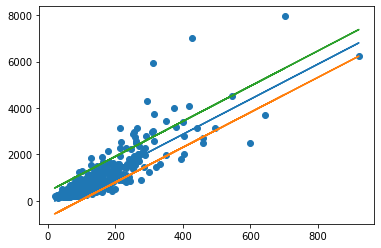

0.7510589256474233


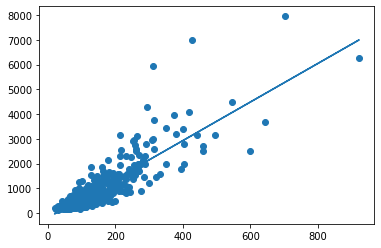

0.7518418516724226


In [442]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

std_samples = trace["std"]
alpha_samples = trace["alpha"]
beta_samples = trace["beta"]

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N) 

pred = [ alpha_samples.mean() + beta_samples.mean() * x for x in X_test ]
plt.scatter(X_test, y_test)
plt.plot(X_test, pred)
pred_min = [ np.quantile(alpha_samples + beta_samples * x + noise, 0.05) for x in X_test ]
plt.plot(X_test, pred_min)
pred_max = [ np.quantile(alpha_samples + beta_samples * x + noise, 0.95) for x in X_test ]
plt.plot(X_test, pred_max)
np.quantile(alpha_samples, 0.05)
plt.show()
print(r2_score(y_test, pred))

model = LinearRegression()
model.fit(np.array([X_test]).T, y_test)
pred = model.predict(np.array([X_test]).T)
plt.scatter(X_test, y_test)
plt.plot(X_test, pred)
plt.show()
print(r2_score(y_test, pred))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [std_base]
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:11<00:00, 1772.37draws/s]
The number of effective samples is smaller than 10% for some parameters.


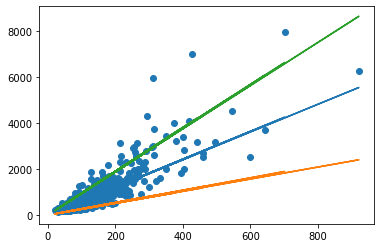

0.7131390557027895


In [506]:
import theano.tensor as tt
with pm.Model() as model:    
    beta = pm.Normal("beta", mu=0, sd=5000)
    alpha = pm.Normal("alpha", mu=0, sd=5000)
    
    std_base = pm.Uniform("std_base", 0, 5000)
    std = pm.Deterministic("std", std_base * X_train)
    
    mean = pm.Deterministic("mean", alpha + beta * X_train)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=y_train)
    
    trace = pm.sample(10000, step=pm.Metropolis())
    
std_samples = trace["std_base"][10000:]
alpha_samples = trace["alpha"][10000:]
beta_samples = trace["beta"][10000:]

N = std_samples.shape[0]

preds = [ np.random.normal(np.mean(alpha_samples + beta_samples * x), np.mean(std_samples * x), N) for x in X_test ]
pred = [ y.mean() for y in preds ]
plt.scatter(X_test, y_test)
plt.plot(X_test, pred)
pred_min = [ np.quantile(y, 0.05) for y in preds ]
plt.plot(X_test, pred_min)
pred_max = [ np.quantile(y, 0.95) for y in preds ]
plt.plot(X_test, pred_max)
plt.show()
print(r2_score(y_test, pred))

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [std_base]
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:15<00:00, 1362.09draws/s]
The number of effective samples is smaller than 10% for some parameters.


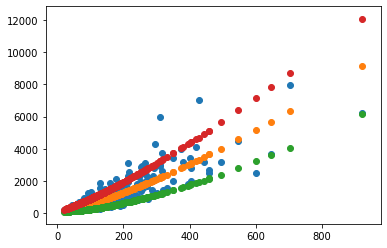

0.740781112501113


In [507]:
import theano.tensor as tt
with pm.Model() as model:    
    beta = pm.Normal("beta", mu=0, sd=5000)
    alpha = pm.Normal("alpha", mu=0, sd=5000)
    
    std_base = pm.Uniform("std_base", 0, 5000)
    std = pm.Deterministic("std", std_base * X_train)
    
    mean = pm.Deterministic("mean", alpha + X_train.values ** beta)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=y_train)
    
    trace = pm.sample(10000, step=pm.Metropolis())
    
std_samples = trace["std_base"][10000:]
alpha_samples = trace["alpha"][10000:]
beta_samples = trace["beta"][10000:]

N = std_samples.shape[0]

preds = [ np.random.normal(np.mean(alpha_samples + x ** beta_samples), np.mean(std_samples * x), N) for x in X_test ]
pred = [ y.mean() for y in preds ]
plt.scatter(X_test, y_test)
plt.scatter(X_test, pred)
pred_min = [ np.quantile(y, 0.05) for y in preds ]
plt.scatter(X_test, pred_min)
pred_max = [ np.quantile(y, 0.95) for y in preds ]
plt.scatter(X_test, pred_max)
plt.show()
print(r2_score(y_test, pred))